In [1]:
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
from matplotlib.pyplot import *
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
from scipy import fftpack
from IPython.display import display
import pims
import scipy.optimize as optimization
import pandas as pd
import pytube

# Example Particle tracking on video from youtube

The video is available on youtube and is the brownian motion of trace particles in water. The tracers particle have a diameter of 400nm. The original video was captured with a Phantom camera at a resolution of 512x512, converted to mp4 with the phantom camera software and uploaded on youtube. 

The frame rate is 100 fps and the number of frames are 300 for this example video. A more tipical number of frames for a microrheology experiment is about 3000. Once uploaded on youtube the video is converted and the maximum available resolution stream is 480x480.

In [3]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/AkRXCm2eZSA?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


# Getting the video from youtube

Using the pytube library is easy to download the video, the title and the description of the video that contain in json format the metadata necessary for the analysis.

* 'muperpix': 0.1, **micron per pixel resolution in the original video (before youtube resized it)**
* 'filename': '400nm 100dil water 01umpix 100fps short.cin', **original filename**
* 'fps': 100, **frame per second during acquisition - the playback rate is 25 and set by youtube**
* 'radius_tracer_nm': 200, **radius of the tracers in nanometer**
* 'Fluorescence': False, **specify the acquisition mode**
* 'temperature_C': 25, **Temperature in Celsius**
* 'shape_x': 512, **frame shape width in px**
* 'shape_y': 512} **frame shape height in px**

the json string available in the video decription can be easily converted to a dictionary that can be used to retreive the necessary information for the analysis

In [4]:
from pytube import YouTube

In [5]:
yt_video=YouTube('https://www.youtube.com/watch?v=AkRXCm2eZSA&feature=youtu.be')

In [6]:
yt_video.title

'microrheology_water_25C'

In [7]:
yt_video.description

'{  "muperpix": 0.1,  "filename": "400nm 100dil water 01umpix 100fps short.cin",  "fps":100,  "radius_tracer_nm":200 ,  "Fluorescence":false,  "temperature_C":25,  "shape_x":512,  "shape_y":512}'

In [16]:
import json
info=json.loads(yt_video.description)
info

{'muperpix': 0.1,
 'filename': '400nm 100dil water 01umpix 100fps short.cin',
 'fps': 100,
 'radius_tracer_nm': 200,
 'Fluorescence': False,
 'temperature_C': 25,
 'shape_x': 512,
 'shape_y': 512}

In [17]:
yt_video.streams.all()

[<Stream: itag="43" mime_type="video/webm" res="360p" fps="30fps" vcodec="vp8.0" acodec="vorbis">,
 <Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">,
 <Stream: itag="36" mime_type="video/3gpp" res="240p" fps="30fps" vcodec="mp4v.20.3" acodec="mp4a.40.2">,
 <Stream: itag="17" mime_type="video/3gpp" res="144p" fps="30fps" vcodec="mp4v.20.3" acodec="mp4a.40.2">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401e">,
 <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d4015">,
 <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400c">,
 <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">,
 <Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">]

In [12]:
yt_video.streams.filter(adaptive=True).first().download('./')

'./microrheology_water_25C.mp4'

# Using the PIMS library to access the video frames

Once the video is downloaded in the local folder (in this case the size is less than 2Mb so is reasonable to download it) we use the trackpy library that include the pims library to enable random access to the frames

In [25]:
pims_video=pims.Video('./microrheology_water_25C.mp4')

In [26]:
pims_video

<Frames>
Length: 300 frames
Frame Shape: 480 x 480
Pixel Datatype: uint8

the pims object is a very convenient container for the video but also for the video metadata so we can add the info dictionary as an attribute of the video.

In [27]:
pims_video.info=info

In [28]:
pims_video.frame_shape

(480, 480, 3)

Finally we add a processing function which is called every time we request a frame to convert the frame to a grayscalw

In [29]:
from pims import pipeline

@pipeline
def as_grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

#pims_video=as_grey(pims.Video('microrhology_water_25C.mp4'))
pims_video=as_grey(pims.Video('microrheology_water_25C.mp4'))

In [30]:
pims_video.info=info
info

{'muperpix': 0.1,
 'filename': '400nm 100dil water 01umpix 100fps short.cin',
 'fps': 100,
 'radius_tracer_nm': 200,
 'Fluorescence': False,
 'temperature_C': 25,
 'shape_x': 512,
 'shape_y': 512}

In [31]:
shape(pims_video[0])

(480, 480)

At this point we have access to the frames just by requesting the frame number

Frame([[129., 126., 122., ..., 124., 124., 124.],
       [118., 117., 114., ..., 117., 117., 117.],
       [118., 118., 118., ..., 121., 121., 121.],
       ...,
       [125., 125., 125., ..., 124., 124., 124.],
       [124., 124., 124., ..., 123., 123., 123.],
       [117., 117., 117., ..., 117., 117., 117.]])
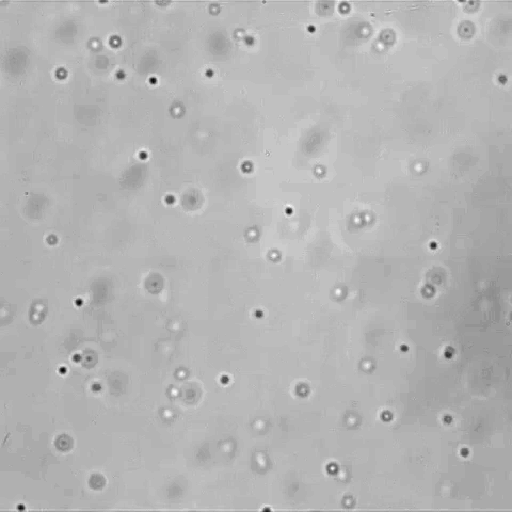

In [32]:
pims_video[0]

Frame([[123., 125., 125., ..., 123., 123., 123.],
       [115., 116., 116., ..., 118., 118., 118.],
       [122., 124., 124., ..., 123., 123., 123.],
       ...,
       [122., 119., 121., ..., 124., 124., 124.],
       [123., 122., 122., ..., 123., 123., 123.],
       [117., 116., 116., ..., 117., 116., 116.]])
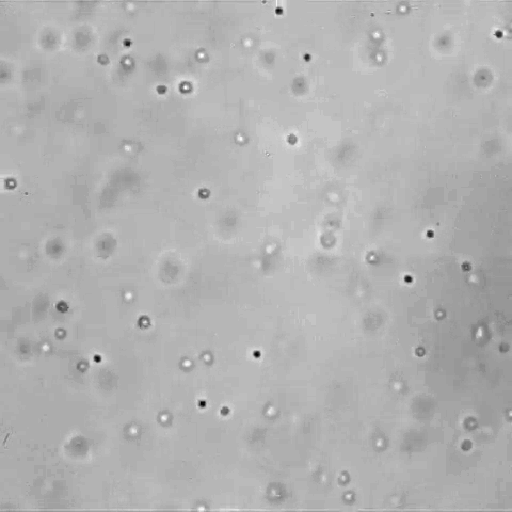

In [34]:
pims_video[-1]

or we can define a widget to scroll the video in the notebook.

In [36]:
#Define simple video browser with ipywidgets

def browse_images_ptm(video):
    frames=len(video)
    interval=1/video.info['fps']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        pyplot.figure(figsize=(6,6))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w


In [37]:
browse_images_ptm(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-…

# Particle tracking with trackpy

we use the trackpy library for the tracking

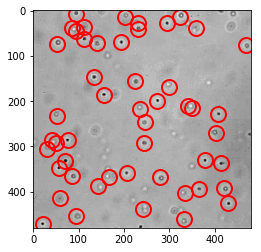

In [39]:
import trackpy as tp
fnum=10
fsingle = tp.locate(pims_video[fnum], 9, invert=True, minmass=100)
tp.annotate(fsingle, pims_video[fnum])

tracking all the 300 frames only ~30 sec on a standard computer about 1 min on binder

In [41]:
f = tp.batch(pims_video, 9, minmass=100, invert=True)
pims_video.result_PT=f

Frame 299: 35 features


In [42]:
def browse_images_tracked(video):
    frames=len(video)
    f=video.result_PT
    interval=1/video.info['fps']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        pyplot.figure(figsize=(8,8))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.plot(f.x[f.frame==framenum],f.y[f.frame==framenum],'o')
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w

In [43]:
browse_images_tracked(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-…

In [44]:
t = tp.link_df(f, 5, memory=3)

Frame 299: 35 trajectories present.


In [45]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,9.599045,320.210024,206.422424,2.310090,0.325376,11.823719,-5652.0,0.095111,0,0
24,275.940206,322.167010,119.468825,2.462921,0.275222,4.433895,-5760.0,0.139455,0,1
25,282.966370,73.645462,607.936208,2.122466,0.050934,31.037262,-4525.0,0.022026,0,2
26,291.886513,29.860197,149.767105,2.386227,0.256244,6.404514,-5557.0,0.074322,0,3
27,293.965361,242.244179,433.782683,2.241901,0.103874,18.967216,-4927.0,0.030342,0,4


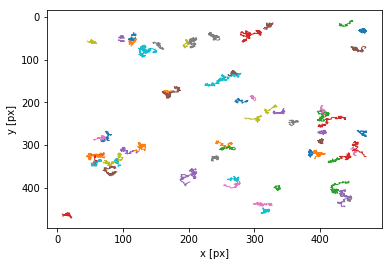

In [46]:
t1 = tp.filter_stubs(t, 50)
tp.plot_traj(t1)

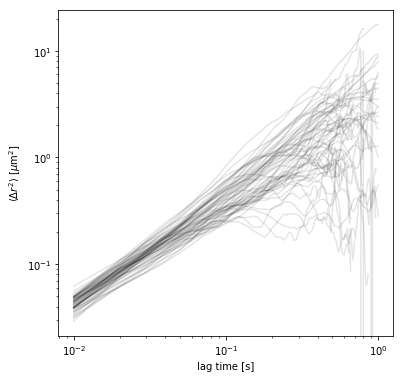

In [47]:
im = tp.imsd(t1, pims_video.info['muperpix']*info['shape_x']/480, pims_video.info['fps'])
im.plot(loglog=True, style='k-', alpha=0.1, legend=False, figsize=(6,6))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]');

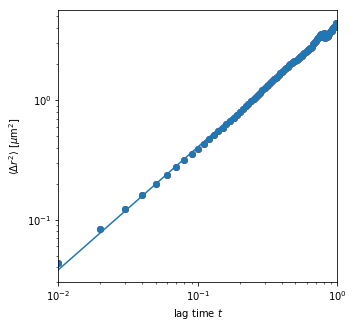

,n,A
msd,1.025472,4.310813


In [48]:
em = tp.emsd(t, pims_video.info['muperpix']*info['shape_x']/480, pims_video.info['fps'],max_lagtime=100)
em.plot(loglog=True, style='ro', figsize=(5,5))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
pyplot.xlabel('lag time $t$')

result=tp.utils.fit_powerlaw(em)
result

For Newtonian liquids:
* $n=1$
* $A=4D$, where $D$ is the particles’ diffusivity.

$D$ is related to viscosity $\eta$, particle radius $a$, and temperature $T$ as:
$$D=\frac{kT}{6 \pi \eta a}$$

In [49]:
kb=1.380E-23
tempK=273+pims_video.info['temperature_C']

float(kb*tempK*4/(6*3.14*result.A*1e-12*pims_video.info['radius_tracer_nm']*1e-9))

0.0010127104600918195

The result 0.001 Pa s is the viscosity of the water